# Combustion Chemistry in Isobaric Reactor: Postprocessing DeepONet

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd
from   numpy                         import diff
import                           cantera as ct
import tensorflow                        as tf

### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE
from PCAfold         import PCA          as PCAA


import romnet                            as rmnt


# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

3.9.6 (default, Aug 11 2021, 06:39:25) 
[GCC 8.5.0 20210514 (Red Hat 8.5.0-3)]


2022-06-30 08:48:51.564412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr//lib/:/home/sventur/LIBRARIES/MPC/mpc-1.2.1-install//lib/:/home/sventur/LIBRARIES/MPFR/mpfr-4.1.0-install//lib/:/home/sventur/LIBRARIES/GMP/gmp-6.2.1-install//lib/::/home/sventur/LIBRARIES/BOOST/boost_1_78_0-install//lib/:/home/sventur/APPS/SCREEN/screen-4.8.0-install//lib/:/home/sventur/LIBRARIES/NCURSES/ncurses-6.1-install//lib/:/home/sventur/LIBRARIES/MPC/mpc-1.2.1-install//lib/:/home/sventur/LIBRARIES/MPFR/mpfr-4.1.0-install//lib/:/home/sventur/LIBRARIES/GMP/gmp-6.2.1-install//lib/::/home/sventur/LIBRARIES/BOOST/boost_1_78_0-install//lib/:/home/sventur/APPS/SCREEN/screen-4.8.0-install//lib/:/home/sventur/LIBRARIES/NCURSES/ncurses-6.1-install//lib/:
2022-06-30 08:48:51.564447: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignor

In [2]:
DataDir          = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/0DReact_Isobaric_5000000Cases_H2_SmallSteps/')

path_to_run_fld  = os.path.join(WORKSPACE_PATH, 'ROMNet/0DReact_Isobaric_5000000Cases_H2_SmallSteps/DeepONet/Run_12/')

FigDir           = None #os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')


# DataType         = 'train'
# CasesVec         = range(0,5000,500)#100,10)
DataType         = 'test'
CasesVec         = range(10) #[1,0,2]



NSamples         = 1

FixedMinVal      = 1.e-14 

PCA_NAME         = 'All'

scale            = 'lin'
MinVal           = 1.e-40

 
ColorVec         = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']
LineVec          = ['-',':','--','.-']*10

## Loading ROMNet's Input Data File

In [3]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg = 0
InputData.path_to_run_fld  = path_to_run_fld


[ROMNet]: Reading Input File from:  /home/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/0DReactor/DeepONet/../../../../../../ROMNet/0DReact_Isobaric_5000000Cases_H2_SmallSteps/DeepONet/Run_12/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


## Loading Tensorflow's Model for the Network 

In [4]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.nn, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - deeponet.py               ]:   Constructing Deep Operator Network: 
[ROMNet - system_of_components.py   ]:     Mapping Branch-to-Trunk (i.e., self.branch_to_trunk Object):  [0 1]
[ROMNet - system_of_components.py   ]:     Constructing System of Components: DeepONet


2022-06-30 08:48:54.394057: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr//lib/:/home/sventur/LIBRARIES/MPC/mpc-1.2.1-install//lib/:/home/sventur/LIBRARIES/MPFR/mpfr-4.1.0-install//lib/:/home/sventur/LIBRARIES/GMP/gmp-6.2.1-install//lib/::/home/sventur/LIBRARIES/BOOST/boost_1_78_0-install//lib/:/home/sventur/APPS/SCREEN/screen-4.8.0-install//lib/:/home/sventur/LIBRARIES/NCURSES/ncurses-6.1-install//lib/:/home/sventur/LIBRARIES/MPC/mpc-1.2.1-install//lib/:/home/sventur/LIBRARIES/MPFR/mpfr-4.1.0-install//lib/:/home/sventur/LIBRARIES/GMP/gmp-6.2.1-install//lib/::/home/sventur/LIBRARIES/BOOST/boost_1_78_0-install//lib/:/home/sventur/APPS/SCREEN/screen-4.8.0-install//lib/:/home/sventur/LIBRARIES/NCURSES/ncurses-6.1-install//lib/:
2022-06-30 08:48:54.394090: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to

[ROMNet - component.py              ]:       Constructing Component: Branch_1
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<keras.layers.core.dense.Dense object at 0x7f1390794e20>, <keras.layers.core.dense.Dense object at 0x7f1390794160>, <keras.layers.core.dense.Dense object at 0x7f1390794a30>, <keras.layers.core.dense.Dense object at 0x7f13993eb940>, <keras.layers.core.dense.Dense object at 0x7f13993eb9d0>])
[ROMNet - component.py              ]:       Constructing Component: Branch_2
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<keras.layers.core.dense.Dense object at 0x7f139078a2b0>, <keras.layers.core.dense.Dense object at 0x7f139078a880>, <keras.layers.core.dense.Dense object at 0x7f139079d640>, <keras.layers.core.dense.Dense object at 0x7f1390704940>, <keras.layers.core.dense.Dense object at 0x7f13907b1700>])
[ROMNet - component.py              ]:  


[ROMNet - model_tf.py    ]:   Saving ML Model Parameters to File:  /home/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/0DReactor/DeepONet/../../../../../../ROMNet/0DReact_Isobaric_5000000Cases_H2_SmallSteps/DeepONet/Run_12//Model/Params/Initial.h5
'save_params' took 0.041593 s

'build' took 1.738842 s



## Evaluating DeepONet on Test Data

### Loading Simulations Info

In [5]:
# FileName     = DataDir + '/Orig/train/ext/y.csv.1'
# Data         = pd.read_csv(FileName, header=0)
# VarNames     = list(Data.columns)
# VarNames.remove('t')

FileName     = DataDir + '/Orig/train/ext/CleanVars.csv'
Data         = pd.read_csv(FileName, header=0)
VarNamesAnti = list(Data.columns)


FileName     = DataDir + '/Orig/'+DataType+'/ext/SimIdxs.csv'
Data         = pd.read_csv(FileName, header=0)
SimIdxs      = Data.to_numpy(int)

FileName     = DataDir + '/Orig/'+DataType+'/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
n_ics        = len(ICVecs)

### Loading Variables Info

In [6]:
Vars  = VarNamesAnti

Vars0 = []
for Var in Vars:
    Vars0.append(str(Var)+'0')
    
InputVars = Vars0+['t']

### Loading and Plotting Test/Training Data

In [7]:
# VarOI      = 'O2'
# VarOI_Name = 'O2'


# iVar     = Vars.index(VarOI)


# ax   = []
# fig  = []
# fig1 = plt.figure()
# fig.append(fig1)
# ax.append(plt.axes())

# MSE   = 0.

# jTest = 0
# for iTest in [3]:#CasesVec:
#     Nts              = SimIdxs[iTest,1]-SimIdxs[iTest,0]
#     P0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,0]
#     EqRatio0Vec      = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,1]
#     T0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,2]
    
    
#     #####################################################################################################
#     FileName     = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
#     Data         = pd.read_csv(FileName, header=0)[['t']+Vars]
#     tVec0        = Data.to_numpy()[0,0]
#     tVec         = Data.to_numpy()[:,0] - tVec0
#     tVec[tVec == 0.] = FixedMinVal
#     y_Data       = Data[Vars].to_numpy()
#     print('T = ', Data['T'].to_numpy()[0], 'K')
    
#     DFa = Data.iloc[range(1,len(Data))]['t'].reset_index(drop=True) - Data.iloc[range(0,len(Data)-1)]['t'].reset_index(drop=True)
#     DFb = Data.iloc[range(0,len(Data)-1)][Vars].reset_index(drop=True)
#     DFc = Data.iloc[range(1,len(Data))][Vars].reset_index(drop=True)
#     DataAll         = pd.concat( [DFa, DFb, DFc], axis=1, ignore_index=True )
#     DataAll.columns = ['t'] + Vars0 + Vars
        
#     if (jTest == 0):
#         Label1 = 'ODE'
#         Label2 = 'PCA'
#         Label3 = 'DeepONet'
#         #Label3 = 'flexDeepONet'
#     else:
#         Label1 = ''
#         Label2 = ''
#         Label3 = ''

#     ax[0].plot(tVec+tVec0, y_Data[:,iVar],  'o-', c=ColorVec[0], label=Label1)

    
# #     DataAll_        = DataAll.copy()
    
# #     DataAll_[Vars0] = np.log10( DataAll_[Vars0].to_numpy() + 1.e-14 ) * (1.)# + np.random.normal(0., 5.e-2, (len(DataAll_),1)))
# #     y_Pred          = 10.**( model.predict(DataAll_[InputVars]) ) 
    
# #     #DataAll_[Vars0] = DataAll_[Vars0].to_numpy()*(1.)#+np.random.normal(0., 5.e-2, (len(DataAll_),1)))
# #     #y_Pred          = model.predict(DataAll_[InputVars])
    
# #     yPredDF         = pd.DataFrame(y_Pred, columns=Vars)
# #     yPredDF['t']    = tVec[1::]
    
    
#     iStart       = 0
#     y_Pred       = np.log10( DataAll[Vars0].iloc[iStart:iStart+1].to_numpy() + 1.e-30 )
#     #y_Pred       = DataAll[Vars0].iloc[iStart:iStart+1].to_numpy()
#     yPredDF      = pd.DataFrame(y_Pred, columns=Vars)
#     t            = Data['t'].iloc[iStart]
#     yPredDF['t'] = t
#     j            = 0
#     for i in range(iStart,100): #len(DataAll)):
#         Deltat         = 1.e-5#DataAll['t'].iloc[i]
        
#         #DataStart      = DataAll[Vars0].iloc[i:i+1]
#         DataStart      = pd.DataFrame(y_Pred, columns=Vars0)
#         DataStart['t'] = Deltat

#         y_Pred         = model.predict(DataStart[InputVars])
#         t             += Deltat 
        
#         yPredDF_       = pd.DataFrame(10.**(y_Pred), columns=Vars)
#         #yPredDF_       = pd.DataFrame(y_Pred, columns=Vars)
#         yPredDF_['t']  = t
#         yPredDF        = pd.concat([yPredDF, yPredDF_], axis=0)
        
#         j += 1
    
#     yPredDF.reset_index(drop=True, inplace=True)
    
    
    
#     ax[0].plot(yPredDF['t'].to_numpy()[0:-1], yPredDF[VarOI].to_numpy()[1:], '+:', c=ColorVec[1], label=Label3)
     
#     jTest += 1
    

# ax[0].set_xscale('log')
# ax[0].set_xlabel('Time [s]')
# if (VarOI == 'T'):
#     ax[0].set_ylabel('Temperature [K]')
# else:
#     ax[0].set_ylabel(r''+VarOI_Name+', Mass Fraction')
# ax[0].set_xlim([1.e-8,1.e-2])
# ax[0].legend()
# ax[0].set_yscale('log')  
    
# # MSE_ = MSE.sum(axis=0) / len(CasesVec) / (MSE.shape[0])
# # print('Mean Squared Error = ', MSE_)
    

# if (FigDir):
#     fig[0].savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_'+VarOI+'.eps', format='eps', bbox_inches='tight')

In [8]:
#DataDir_      = DataDir
DataDir_      = '/home/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/0DReactor/DeepONet/../../../../../../ROMNet/Data/0DReact_Isobaric_5000000Cases_H2_SmallSteps/'

FileName      = DataDir_ + '/Orig/train/pts/Input.csv'
Data0         = pd.read_csv(FileName, header=None, skiprows=1)
Data0.columns = ['t0']+InputVars[0:-1]

FileName      = DataDir_ + '/Orig/train/pts/Output.csv'
Data          = pd.read_csv(FileName, header=None, skiprows=1)
Data.columns  = ['t']+Vars

Data          = pd.concat([Data0, Data], axis=1)
#Data['t']     = Data['t'] - Data['t0'] 

Data          = Data.dropna(axis=0)

In [9]:
y_Pred        = pd.DataFrame(model.predict(Data[InputVars]), columns=InputData.output_vars)

Text(0, 0.5, '$n_{NH}$, Predicted')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Arial
findfont: Font family ['Charter'] not found. Falling back to DejaVu Sans.
findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'monospace' not found because none of the following families were found: Arial
findfont: Font family ['Charter'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Charter'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Arial


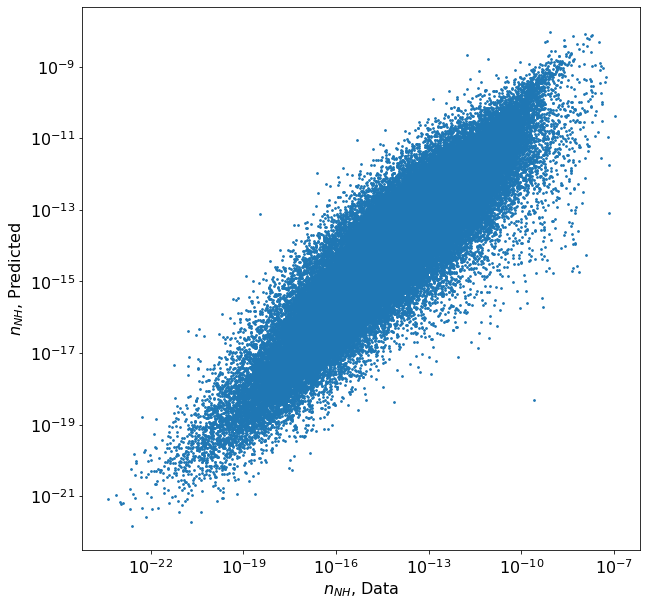

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(10**(Data['NH']), 10**(y_Pred['NH']), s=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$n_{NH}$, Data')
plt.ylabel(r'$n_{NH}$, Predicted')
#plt.xlabel(r'$T$, Data')
#plt.ylabel(r'$T$, Predicted')
#plt.plot([1000,3000], [1000,3000], 'r')
#plt.plot([1.e-3,1], [1.e-3,1], 'r')
#plt.plot([1.e-15,1.e-2], [1.e-15,1.e-2], 'r')
#plt.plot([1.e-30,1.e-5], [1.e-30,1.e-5], 'r')

In [11]:
y_Pred

,N,NH
0,-15.970937,-16.046949
1,-12.235139,-12.487151
2,-14.159773,-14.866181
3,-17.736271,-17.116296
4,-13.378087,-14.504065
...,...,...
119085,-12.095069,-13.073012
119086,-12.108311,-12.786888
119087,-15.523898,-12.962057
119088,-16.911834,-15.057219


In [12]:
asa

NameError: name 'asa' is not defined

## Plotting Loss Histories

In [ ]:
Data = pd.read_csv(path_to_run_fld+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['res_loss'],     label='Training')
# plt.plot(Data['val_res_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Residual Loss [MSE]')
# plt.legend()
# plt.yscale('log')


fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')


# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

## Evaluating Trunk's Outputs

In [ ]:
iTrunk           = 3
iTest            = 0


FileName         = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
Data             = pd.read_csv(FileName, header=0)[['t']+Vars]

fig = plt.figure()
plt.plot(Data['t'], Data[Vars[iTrunk]])
plt.xscale('log')
plt.xlabel('Time [s]')
plt.ylabel(r'$\eta_{'+str(iTrunk+1)+'}$')



iVarVec = range(0,32,1)

tVecTot = np.logspace(-14,4,1000)

output_ = model.net.system_of_components['DeepONet'].components['Trunk_'+str(iTrunk+1)].call(tVecTot[...,np.newaxis], model.net.layers_dict, None, training=False)

fig = plt.figure()

for iVar in iVarVec:

    plt.plot(tVecTot, output_[:,iVar])

#plt.xlim([1.e-6, 1.e-2])
plt.xscale('log')
plt.xlabel('Time [s]')
plt.ylabel(r'$\phi_{'+str(iTrunk+1)+'_{i}}$')

## Evaluating Branches' Outputs

In [ ]:
# FileName     = DataDir + '/Orig/train/ext/SimIdxs.csv'
# Data         = pd.read_csv(FileName, header=0)
# SimIdxs      = Data.to_numpy(int)


# FileName     = DataDir + '/Orig/train/ext/ICs.csv'
# Data         = pd.read_csv(FileName)
# ICVecs       = Data.to_numpy()
# n_ics        = len(ICVecs)
n_ics         = 500

Cols   = []
NewFlg = True
for iC in range(n_ics):

    try:
        
        FileName         = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iC+1)
        Data             = pd.read_csv(FileName, header=0)[['t']+Vars]

        DataICTemp       = Data[Vars].iloc[0]

        if (NewFlg):
            DataIC           = DataICTemp
            NewFlg           = False
        else:
            DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols.append(str(iC+1))
            
    except:
        pass

tVec              = Data['t']
DataIC            = DataIC.T.reset_index(drop=True, inplace=False)

DataIC.head()

In [ ]:
iBranch = 0
iVar    = 0



output_branch = model.net.system_of_components['DeepONet'].components['Branch_'+str(iBranch+1)].call(DataIC.to_numpy(), model.net.layers_dict, None, training=False)



#%matplotlib qt

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(DataIC['T'], DataIC['H2'], output_branch[:,iVar], c='r')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$H_2$')
#ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_{'+str(iVar+1)+'}}$')
ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_D}$')

## Evaluating Rigid Block + Trunk's Outputs

In [ ]:
n_ics         = 10

Cols   = []
NewFlg = True

# FileName         = DataDir + '/Orig/'+DataType+'/ext/y.csv.1'
# DataAll          = pd.read_csv(FileName, header=0)[Vars]
# DataAllt         = pd.read_csv(FileName, header=0)[Vars+['t']]
DataAll          = DataIC.copy()
DataAllt         = pd.read_csv(FileName, header=0)[Vars+['t']]

DataBranch       = model.net.layers_dict['DeepONet']['Branch']['DeepONet-Branch_Normalization'](DataAll.to_numpy())

In [ ]:
output_stretch = model.net.system_of_components['DeepONet'].components['Stretch'].call(DataBranch, model.net.layers_dict, None, training=False)

try:
    output_shift   = model.net.system_of_components['DeepONet'].components['Shift'].call(DataBranch, model.net.layers_dict, None, training=False)
    ShiftFlg = True     
except:
    ShiftFlg = False

In [ ]:
VarNames=['T',
 'H_{2}',
 'H',
 'O',
 'O_{2}',
 'OH',
 'H_{2}O',
 'HO_{2}',
 'H_{2}O_{2}',
 'N',
 'NH',
 'NH_{2}',
 'NH_{3}',
 'NNH',
 'NO',
 'NO_{2}',
 'N_{2}O',
 'HNO',
 'N_{2}']




fig = plt.figure()

for iBranch in [0]:#,1,2,3,5,9,12]:
    plt.scatter(DataAllt['t'], output_stretch[:,iBranch], label=r'$j='+VarNames[iBranch]+'$', s=30)
    
plt.xlabel(r'$T_0$')
plt.ylabel(r'$\bar{t}_j$')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([1000,2000])
#plt.ylim([0,80])

plt.legend(fontsize=30)
#ax.set_zscale('log')

if (FigDir):
    plt.savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_RigidOutput_2D.eps', format='eps', bbox_inches='tight')
    


if (ShiftFlg):

    fig = plt.figure()

    for iBranch in [0]:#,1,2,3,5,9,12]:
        plt.scatter(DataAllt['t'], output_shift[:,iBranch], label=r'$j='+VarNames[iBranch]+'$', s=30)

    plt.xlabel(r'$T_0$')
    plt.ylabel(r'$\bar{t}_j$')
    #plt.yscale('log')
    #plt.xlim([1000,2000])
    #plt.ylim([0,80])

    plt.legend(fontsize=30)
    #ax.set_zscale('log')

    if (FigDir):
        plt.savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_RigidOutput_2D.eps', format='eps', bbox_inches='tight')


In [ ]:
iVarVec   = [0,1,2,3,5,9,12]

for iVar in iVarVec:

    NewFlg   = True
    fig, ax1 = plt.subplots()
    ax2      = ax1.twiny()  # instantiate a second axes that shares the same x-axis
    for iTest in range(10):
        
        FileName         = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
        Data             = pd.read_csv(FileName, header=0)[['t']+Vars]
        
        tVec             = np.maximum(Data['t'].to_numpy(), -1)#FixedMinVal)
        yPCA_Data        = Data[Vars].to_numpy()
        Data0            = Data[Data['t'] == 0.][Vars]
#         yPCA_Data        = ((y_Data[:,ToOrig_Mask] - C[:,0])/D[:,0]).dot(A.T)
#         yPre_Data        = yPCA_Data.dot(A)
#         yAnti_Data       = yPre_Data * D[:,0] + C[:,0]
#         Data0            = pd.DataFrame([yPCA_Data[1,:]], columns=Vars0)

        if NewFlg:
            Label1 = 'ODE'
            Label2 = 'Rigid Block Prepr.'
            NewFlg = False
        else:
            Label1 = None
            Label2 = None

    
        ax1.plot(tVec, yPCA_Data[:,iVar], color=ColorVec[0], label=Label1)
        if (ShiftFlg):
            output_t       = output_stretch[iTest,iVar] * (tVec + output_shift[iTest,iVar])
        else:
            output_t       = output_stretch[iTest,iVar] * (tVec)
        ax2.plot(output_t, yPCA_Data[:,iVar], color=ColorVec[1], label=Label2)

    #plt.vlines(0., ymin=5., ymax=12., linestyles='dashed', color=ColorVec[1])
    
    color = ColorVec[0]
    ax1.set_xlabel(r'Time [s]', size=34)
    if (Vars[iVar] == 'T'):
        ax1.set_ylabel(r'Temperature [K]', color=color, size=34)
    else:
        ax1.set_ylabel(r'$'+VarNames[iVar]+'$, Mass Fraction', color=color, size=34)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xscale('log')

    color = ColorVec[1]
    ax2.set_xlabel(r'      $t/\bar{t}_{'+VarNames[iVar]+'}$ [s]', color=color, size=34, labelpad=10)  # we already handled the x-label with ax1
    #ax2.set_ylabel(r'$x$', color=color, size=34)
    ax2.tick_params(axis='x', labelcolor=color)
    ax2.set_xscale('log')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    #plt.legend(loc=4)
    
    
    if (FigDir):
        plt.savefig(FigDir+'/0DReact_test_DeepONet_'+Vars[iVar]+'_Shift.eps', format='eps', bbox_inches='tight')